In [25]:
# Experiment use Trained simCLR model to Perform TSNE of Embeddings for Test Cifar 10 Dataset

# Import necessary libraries
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE



In [26]:
import torch.nn as nn
import torchvision.models as models

class BaseSimCLRException(Exception):
    """Base exception"""


class InvalidBackboneError(BaseSimCLRException):
    """Raised when the choice of backbone Convnet is invalid."""


class InvalidDatasetSelection(BaseSimCLRException):
    """Raised when the choice of dataset is invalid."""



class ResNetSimCLR(nn.Module):

    def __init__(self, base_model, out_dim):
        super(ResNetSimCLR, self).__init__()
        self.resnet_dict = {"resnet18": models.resnet18(pretrained=False, num_classes=out_dim),
                            "resnet50": models.resnet50(pretrained=False, num_classes=out_dim)}

        self.backbone = self._get_basemodel(base_model)
        dim_mlp = self.backbone.fc.in_features

        # add mlp projection head
        self.backbone.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.backbone.fc)

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
        except KeyError:
            raise InvalidBackboneError(
                "Invalid backbone architecture. Check the config file and pass one of: resnet18 or resnet50")
        else:
            return model

    def forward(self, x):
        return self.backbone(x)

In [27]:
# Define constants
BATCH_SIZE = 128
NUM_WORKERS = 0
NUM_CLASSES = 10
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

def load_simclr(model_path='../../src/SimCLR/runs/Mar25_11-51-42_node3/checkpoint_1000.pth.tar'):
    model = ResNetSimCLR(base_model='resnet18', out_dim=128)
    model.load_state_dict(torch.load(model_path, map_location='cuda')['state_dict'])
    encoder = nn.Sequential(model.backbone)
    encoder.eval()
    return encoder


Files already downloaded and verified


## SimCLR-trained from scratch-cifar-10

In [28]:
import kagglehub
_ = kagglehub.model_download('strawhat56/simclr-1000-checkpoint/Other/default/1')


In [29]:
# /kaggle/input/simclr-1000-checkpoint/other/default/1/checkpoint_1000.pth.tar
# Load the pre-trained model
model = load_simclr(model_path='/kaggle/input/simclr-1000-checkpoint/other/default/1/checkpoint_1000.pth.tar').to('cuda')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_31/3869048790.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

In [30]:
# generate embeddings
def get_embeddings(model, dataloader):
    embeddings = []
    labels = []
    with torch.no_grad():
        for data in dataloader:
            inputs, targets = data
            inputs = inputs.to('cuda')
            outputs = model(inputs)
            embeddings.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    return np.concatenate(embeddings), np.concatenate(labels)


# Plot t-SNE
def plot_tsne(embeddings_2d, labels, model_name):
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='jet', s=5)
    plt.colorbar(scatter)
    plt.title(f't-SNE visualization of CIFAR-10 embeddings using {model_name}')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.show()


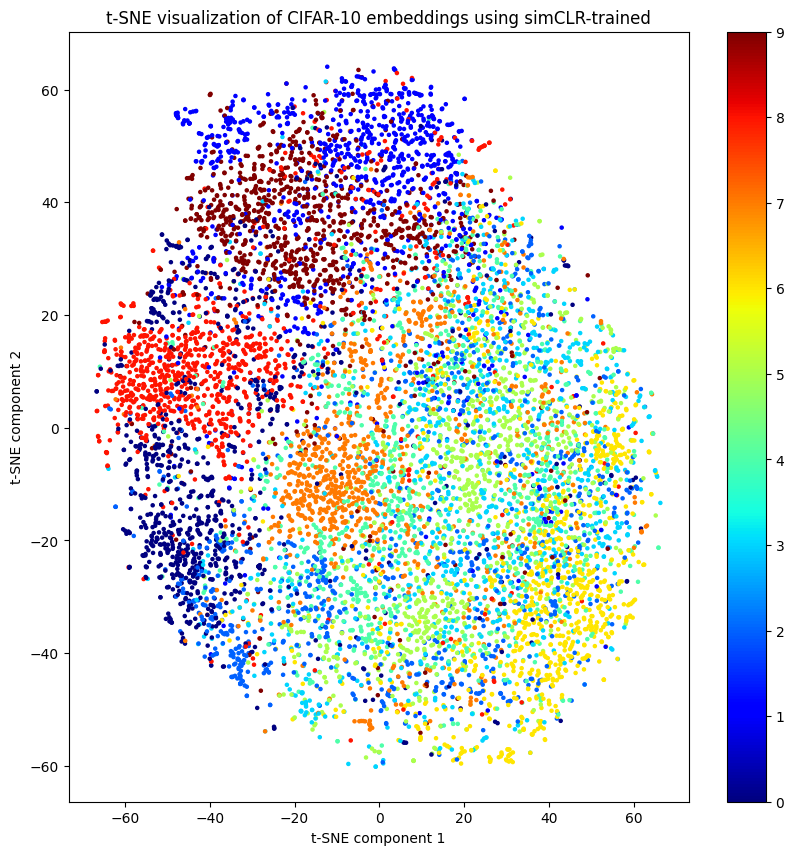

In [31]:
# Get embeddings and labels
embeddings, labels = get_embeddings(model, testloader)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)
plot_tsne(embeddings_2d, labels, "simCLR-trained")

## swAV

In [32]:
model = torch.hub.load('facebookresearch/swav:main', 'resnet50').to('cuda')

Downloading: "https://github.com/facebookresearch/swav/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://dl.fbaipublicfiles.com/deepcluster/swav_800ep_pretrain.pth.tar" to /root/.cache/torch/hub/checkpoints/swav_800ep_pretrain.pth.tar
100%|██████████| 108M/108M [00:00<00:00, 183MB/s]  


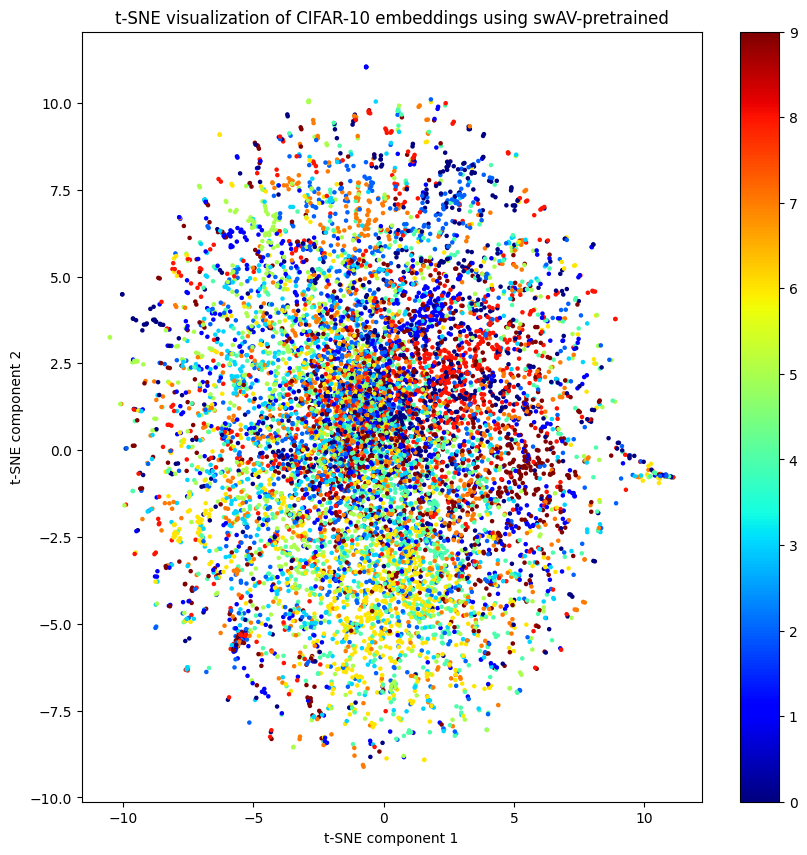

In [33]:
# Get embeddings and labels
embeddings, labels = get_embeddings(model, testloader)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)
plot_tsne(embeddings_2d, labels, 'swAV-pretrained')

## MoCo

In [34]:
import torch
import torch.nn as nn
# import moco.builder as builder
# import moco.loader as loader
import torchvision.models as models
from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

In [37]:
! mkdir checkpoint
! wget https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_800ep/moco_v2_800ep_pretrain.pth.tar -P checkpoint
! wget https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v1_200ep/moco_v1_200ep_pretrain.pth.tar -P checkpoint

--2025-04-30 13:38:30--  https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_800ep/moco_v2_800ep_pretrain.pth.tar
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.167.152.123, 3.167.152.77, 3.167.152.97, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.167.152.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112133139 (107M) [application/octet-stream]
Saving to: ‘checkpoint/moco_v2_800ep_pretrain.pth.tar’

moco_v2_800ep_pretr 100%[===================>] 106.94M   198MB/s    in 0.5s    

2025-04-30 13:38:31 (198 MB/s) - ‘checkpoint/moco_v2_800ep_pretrain.pth.tar’ saved [112133139/112133139]

--2025-04-30 13:38:31--  https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v1_200ep/moco_v1_200ep_pretrain.pth.tar
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.154.185.59, 18.154.185.80, 18.154.185.71, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.154.185.59|:443... connected.
HTTP

In [38]:
model = models.__dict__['resnet50']()
model.fc = nn.Identity()

chpkt = torch.load("/kaggle/working/checkpoint/moco_v2_800ep_pretrain.pth.tar")

state_dict = chpkt['state_dict']
for k in list(state_dict.keys()):
    if k.startswith("module.encoder_q") and not k.startswith("module.encoder_q.fc"):
        # remove prefix
        state_dict[k[len("module.encoder_q.") :]] = state_dict[k]
    # delete renamed or unused k
    del state_dict[k]
msg = model.load_state_dict(state_dict, strict=False)
model = model.to('cuda')
model.eval()
print("Model loaded successfully.")
# print(model)

Model loaded successfully.


/tmp/ipykernel_31/2137669014.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chpkt = torch.load("/kaggle/working/checkpoint/moco_v2_800ep_pretrain.pth.tar")


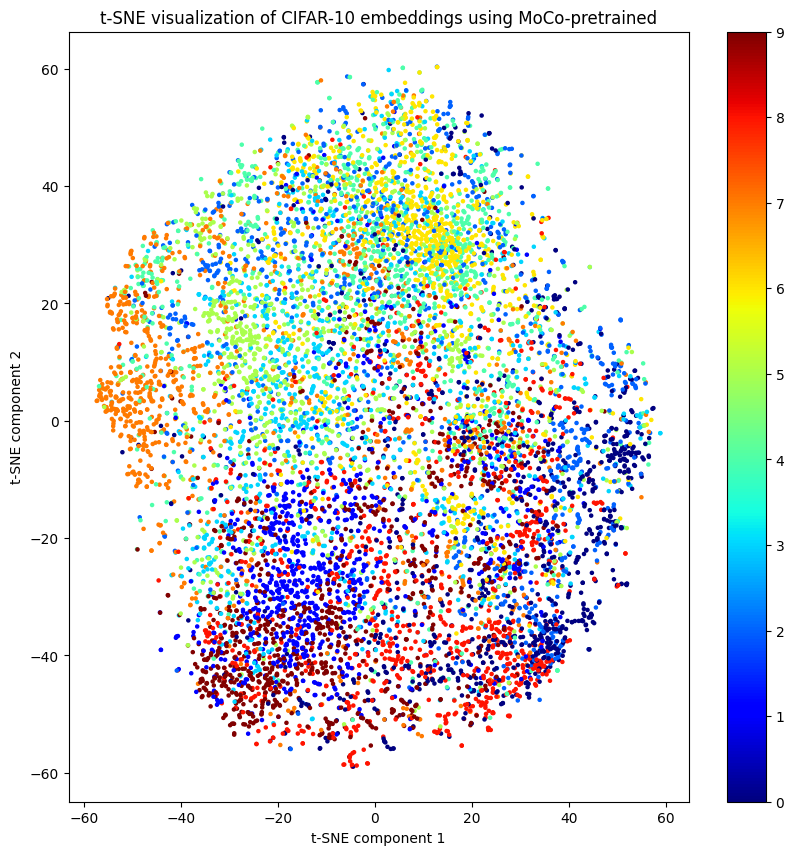

In [39]:
# Get embeddings and labels
embeddings, labels = get_embeddings(model, testloader)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)
plot_tsne(embeddings_2d, labels, 'MoCo-pretrained')